In [1]:
import pandas as pd 
import random
import numpy as np 
import matplotlib.pyplot as plt
from pathlib import Path
import string
import re
import joblib
import json
from collections import Counter
import nltk
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Flatten, Bidirectional,LSTM
from tensorflow.keras.layers import Conv1D,Dropout
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [2]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2021-08-13 07:33:07--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-08-13 07:33:07--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-08-13 07:33:07--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [3]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [62]:
def load_json(jsonFile):
    with open(jsonFile) as file:
        Json_data = json.loads(file.read())
    return Json_data

In [5]:
data = load_json('intents.json')

In [6]:
def frame_data(data):
    df1 = pd.DataFrame(columns=['question','label'])
    df2 = pd.DataFrame(columns=['response','label'])
    for intent in data['intents']:
        for pattern in intent['patterns']:
            w = pattern
            df_to_append = pd.Series([w,intent['tag']], index = df1.columns)
            df1 = df1.append(df_to_append,ignore_index=True)
        for response in intent['responses']:
            w = response
            df_to_append = pd.Series([w,intent['tag']], index = df2.columns)
            df2 = df2.append(df_to_append,ignore_index=True)
    return df1,df2

In [7]:
df1,df2 = frame_data(data)

In [8]:
lemmatizer = WordNetLemmatizer()
vocab = Counter()
labels = []

def tokenizer(text):
    tokens = text.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    tokens = [re_punc.sub('', w) for w in tokens]
    tokens = [word for word in tokens if word.isalpha()]
    tokens = [lemmatizer.lemmatize(w.lower()) for w in tokens]
    tokens = [word.lower() for word in tokens if len(word) > 1]
    return tokens

In [9]:
def remove_stop_words(tokenizer,df,feature):
    doc_without_stopwords = []
    for entry in df[feature]:
        tokens = tokenizer(entry)
        joblib.dump(tokens,'tokens.pkl')
        doc_without_stopwords.append(' '.join(tokens))
    df[feature] = doc_without_stopwords
    return

In [10]:
def create_vocab(tokenizer,df,feature):
    for entry in df[feature]:
        tokens = tokenizer(entry)   
        vocab.update(tokens)
    joblib.dump(vocab,'vocab.pkl')
    return

In [11]:
create_vocab(tokenizer,df1,'question')
remove_stop_words(tokenizer,df1,'question')

In [12]:
vocab_size = len(vocab)
vocab_size

193

In [13]:
df_shuffled=df1.iloc[np.random.permutation(df1.index)].reset_index(drop=True)
df_shuffled.label.value_counts(sort=True)

education     17
skills        17
projects      16
media         15
experience    14
contact       13
about         12
name          11
hello         11
location      11
thanks        10
goodbye       10
Name: label, dtype: int64

In [14]:
test_list = list(df_shuffled.groupby(by='label',as_index=False).first()['question'])
test_list

['about me',
 'tell me how to contact you',
 'tell me your grade',
 'please share your internship experience with me',
 'bye',
 'hi',
 'where are you located',
 'show me your github account',
 'how can address you',
 'what are you passionate about',
 'what language are you proficient in',
 'very kind of you']

In [15]:
test_index = []
for i,_ in enumerate(test_list):
    idx = df_shuffled[df_shuffled.question == test_list[i]].index[0]
    test_index.append(idx)
train_index = [i for i in df_shuffled.index if i not in test_index]

In [16]:
' '.join(list(vocab.keys()))

'hello hey hi good day whats up hows it going greeting morning afternoon evening how are you bye see goodbye have nice farewell gotta go night catch later one take care thank thanks appreciate thats helpful youre great help very kind of am so grateful owe thoughtful lifesaver your name who do what called shall call can address may be want to know should im not sure is location where based located stay home live find in the world skill tell me about tech stack language proficient techinical capability share with coding programming expertise which at developer specialise knowledge technological framework knowledgeable strength talent lie thing project passionate passion interest enjoy technology like show showcase that work on any cool example code done curious most education did study studying now degree level for university currently educational qualification grade academic major majoring something student school yourself more give information please could personal id learn get better 

In [17]:
t=Tokenizer()
def encoder(df,feature):
    entries = [entry for entry in df[feature]]
    t.fit_on_texts(entries)
    joblib.dump(t,'tokenizer_t.pkl')
    vocab_size = len(t.word_index) + 1
    entries = [entry for entry in df[feature]]
    max_length = max([len(s.split()) for s in entries])
    encoded = t.texts_to_sequences(entries)
    padded = pad_sequences(encoded, maxlen=max_length, padding='post')
    return padded, vocab_size

In [18]:
X,vocab_size = encoder(df_shuffled,'question')

In [19]:
df_encoded = pd.DataFrame(X)

In [20]:
df_encoded['label'] = df_shuffled.label
df_encoded

,0,1,2,3,4,5,6,7,8,label
0,83,0,0,0,0,0,0,0,0,hello
1,3,49,4,1,84,6,0,0,0,skills
2,85,0,0,0,0,0,0,0,0,hello
3,86,0,0,0,0,0,0,0,0,goodbye
4,16,50,0,0,0,0,0,0,0,hello
...,...,...,...,...,...,...,...,...,...,...
152,28,0,0,0,0,0,0,0,0,skills
153,192,0,0,0,0,0,0,0,0,thanks
154,41,54,4,1,82,6,0,0,0,education
155,3,4,1,80,6,0,0,0,0,education


In [21]:
for i in range(0,2):
    dt = [0]*9
    dt.append('confused')
    dt = [dt]
    pd.DataFrame(dt).rename(columns = {9:'label'})
    df_encoded = df_encoded.append(pd.DataFrame(dt).rename(columns = {9:'label'}),ignore_index=True)

In [22]:
df_encoded.tail()


,0,1,2,3,4,5,6,7,8,label
154,41,54,4,1,82,6,0,0,0,education
155,3,4,1,80,6,0,0,0,0,education
156,16,193,0,0,0,0,0,0,0,hello
157,0,0,0,0,0,0,0,0,0,confused
158,0,0,0,0,0,0,0,0,0,confused


In [23]:
train_index.append(157)
test_index.append(158)

In [24]:
from sklearn.preprocessing import LabelEncoder
lable_enc = LabelEncoder()

In [25]:
labl = lable_enc.fit_transform(df_encoded.label)
labl

array([ 6, 11,  6,  5,  6, 10,  8, 10,  3,  6, 10,  7,  7,  9,  2,  3,  8,
       11, 12,  4,  2, 11,  8,  9,  0, 11, 12,  2,  5,  0,  9,  3, 10,  4,
        4,  3, 11,  8,  4,  7,  9,  4,  8, 10,  5,  2,  9,  2,  4,  7,  0,
        4,  3,  4,  4,  5,  2, 11,  9,  4,  7,  8,  0, 10, 12,  2,  9,  3,
       11,  0,  4, 11,  5,  8,  3,  8,  3,  6, 12,  2, 11,  3,  9,  4,  4,
        2,  7,  5, 12, 10,  2, 10, 11,  0, 11,  9, 11, 12,  8, 10,  5,  6,
       12, 11,  4,  0, 10, 11,  5,  8,  0, 12,  2,  3,  3,  5,  7,  6,  3,
        6,  7,  0,  6,  8,  0,  9, 11, 10,  3,  7,  8, 10, 10,  2, 10, 12,
        8, 11,  6, 10,  3,  5, 10,  7,  7,  0,  3,  2,  8,  0,  8,  9, 11,
       12,  3,  3,  6,  1,  1])

In [26]:
mapper = {}
for index,key in enumerate(df_encoded.label):
    if key not in mapper.keys():
        mapper[key] = labl[index]
mapper

{'about': 0,
 'confused': 1,
 'contact': 2,
 'education': 3,
 'experience': 4,
 'goodbye': 5,
 'hello': 6,
 'location': 7,
 'media': 8,
 'name': 9,
 'projects': 10,
 'skills': 11,
 'thanks': 12}

In [27]:
joblib.dump(mapper,'mapper.pkl')

['mapper.pkl']

In [28]:
df2.label = df2.label.map(mapper).astype({'label': 'int32'})
df2.to_csv('response.csv',index=False)

In [29]:
train = df_encoded.loc[train_index]
test = df_encoded.loc[test_index]

In [30]:
X_train = train.drop(columns=['label'],axis=1)
y_train = train.label
X_test = test.drop(columns=['label'],axis=1)
y_test = test.label

In [31]:
y_train =pd.get_dummies(y_train).values
y_test =pd.get_dummies(y_test).values

In [32]:
y_train[0].shape,y_test[0].shape

((13,), (13,))

In [33]:
X_train.shape

(146, 9)

In [34]:
max_length = X_train.shape[1]
# output = len(df3.labels.unique())
output = 13

In [35]:
embeddings_index = {}
f = open('glove.6B.50d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [36]:
word_index = t.word_index
EMBEDDING_DIM = 50 # Because we are using the 50D gloVe embeddings

# Getting my embedding matrix
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [37]:
embedding_matrix, embedding_matrix.shape

(array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-1.09190005e-03,  3.33240002e-01,  3.57430011e-01, ...,
         -4.56970006e-01, -4.89690006e-02,  1.13160002e+00],
        [-2.91629992e-02,  8.17690015e-01,  3.84700000e-01, ...,
         -5.41859984e-01,  3.24530005e-01,  5.84249973e-01],
        ...,
        [-2.28740007e-01, -5.71869984e-02, -4.41639990e-01, ...,
         -2.94970006e-01,  1.58559993e-01,  8.31459984e-02],
        [ 4.73809987e-02,  3.13349992e-01,  5.72910011e-02, ...,
         -5.67919984e-02,  2.11429998e-01,  7.31350034e-02],
        [ 1.20990001e-01,  1.01190001e-01, -1.80649996e-01, ...,
         -2.03620002e-01,  4.19990003e-01,  2.55730003e-01]]), (194, 50))

In [38]:
early_stopping = EarlyStopping(monitor='val_loss',patience=10)
checkpoint = ModelCheckpoint("model-v1.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 3, verbose = 1, min_delta = 0.0001)
callbacks = [early_stopping,checkpoint,reduce_lr]

In [217]:
def define_model(vocab_size, max_length):
    model = Sequential()

    model.add(Embedding(vocab_size,embedding_matrix.shape[1], input_length=max_length,trainable = False, weights = [embedding_matrix]))
    model.add(Conv1D(filters=50, kernel_size=3,padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=3))
    model.add(Bidirectional(LSTM(25)))
    #model.add(Dropout(0.2))
    model.add(Dense(13,activation = 'softmax'))

    model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])
    model.summary()
    history = model.fit(X_train, y_train, epochs=700, verbose=1,validation_data=(X_test,y_test),callbacks=callbacks)
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss=history.history['loss']
    val_loss=history.history['val_loss']
    return model,acc,val_acc,loss,val_loss
    
model,acc,val_acc,loss,val_loss = define_model(vocab_size, max_length)

Model: "sequential_174"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_174 (Embedding)    (None, 9, 50)             9700      
_________________________________________________________________
conv1d_174 (Conv1D)          (None, 9, 50)             7550      
_________________________________________________________________
max_pooling1d_160 (MaxPoolin (None, 3, 50)             0         
_________________________________________________________________
bidirectional_172 (Bidirecti (None, 50)                15200     
_________________________________________________________________
dense_175 (Dense)            (None, 13)                663       
Total params: 33,113
Trainable params: 23,413
Non-trainable params: 9,700
_________________________________________________________________
Epoch 1/700
5/5 [==============================] - 6s 260ms/step - loss: 2.5447 - accuracy: 0.0411 - val_loss:

Model: "sequential_174"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_174 (Embedding)    (None, 9, 50)             9700      
_________________________________________________________________
conv1d_174 (Conv1D)          (None, 9, 50)             7550      
_________________________________________________________________
max_pooling1d_160 (MaxPoolin (None, 3, 50)             0         
_________________________________________________________________
bidirectional_172 (Bidirecti (None, 50)                15200     
_________________________________________________________________
dense_175 (Dense)            (None, 13)                663       
Total params: 33,113
Trainable params: 23,413
Non-trainable params: 9,700
_________________________________________________________________
None


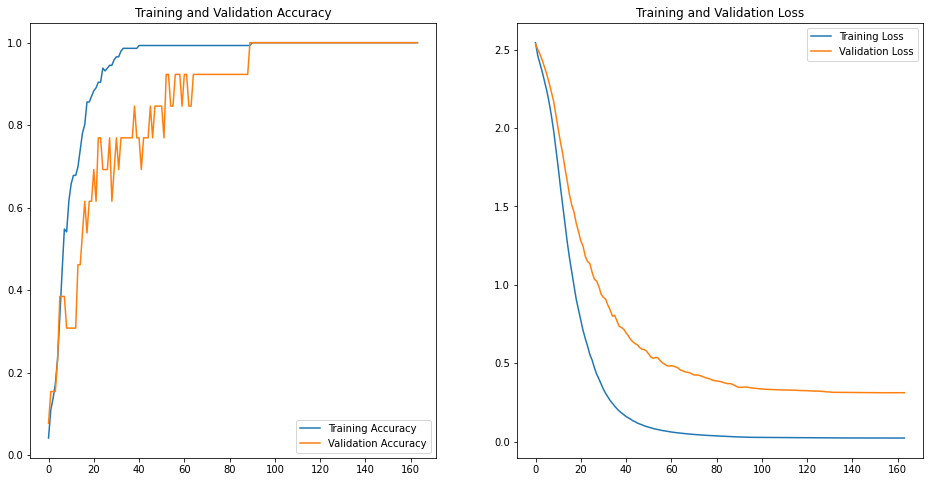

In [218]:
print(model.summary())
plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [219]:
[np.argmax(i) for i in model.predict(X_test)][:12]

[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [220]:
[np.argmax(i) for i in y_test][:12]


[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [221]:
from tensorflow.keras.models import load_model
tester = load_model('model-v1.h5')
tokenizer_t = joblib.load('tokenizer_t.pkl')
mapper = joblib.load('mapper.pkl')
vocab = joblib.load('vocab.pkl')
tester.summary()

Model: "sequential_174"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_174 (Embedding)    (None, 9, 50)             9700      
_________________________________________________________________
conv1d_174 (Conv1D)          (None, 9, 50)             7550      
_________________________________________________________________
max_pooling1d_160 (MaxPoolin (None, 3, 50)             0         
_________________________________________________________________
bidirectional_172 (Bidirecti (None, 50)                15200     
_________________________________________________________________
dense_175 (Dense)            (None, 13)                663       
Total params: 33,113
Trainable params: 23,413
Non-trainable params: 9,700
_________________________________________________________________


In [222]:
def get_text(input):
    input_text = []
    input_text.append(input)
    df_input = pd.DataFrame(input_text,columns=['question'])
    return df_input

In [223]:
def tokenizer(entry):
    tokens = entry.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    tokens = [re_punc.sub('', w) for w in tokens]
    tokens = [word for word in tokens if word.isalpha()]
    tokens = [lemmatizer.lemmatize(w.lower()) for w in tokens]
    tokens = [word.lower() for word in tokens if len(word) > 1]
    return tokens

In [224]:
def remove_stop_words_for_input(tokenizer,df,feature):
    doc_without_stopwords = []
    entry = df[feature][0]
    tokens = tokenizer(entry)
    doc_without_stopwords.append(' '.join(tokens))
    df[feature] = doc_without_stopwords
    return df

In [225]:
def encode_input_text(tokenizer_t,df,feature):
    t = tokenizer_t
    entry = entry = [df[feature][0]]
    encoded = t.texts_to_sequences(entry)
    padded = pad_sequences(encoded, maxlen=9, padding='post')
    return padded

In [226]:
def get_pred(model,encoded_input):
    pred = model.predict(encoded_input)
    pred_dict=[]
    test={}
    for key in mapper.keys():
        test[key]=pred[0][mapper[key]]
        if pred[0][mapper[key]]>0.3:
            pred_dict.append([key,pred[0][mapper[key]]])
    pred_dict.sort(key=lambda x: x[1], reverse=True)
    test ={k: v for k, v in sorted(test.items(), key=lambda item: item[1],reverse=True)}
    print(test)
    return pred_dict

In [227]:
def get_response(intents_list, intents_json,message):
    if not intents_list:
        return "Sorry, I cannot understand you"
    tag = intents_list[0][0]
    if tag == "confused":
        return "Sorry, I cannot understand you"
    list_of_intents = intents_json['intents']
    for i in list_of_intents:
        if i['tag']==tag:
            if i['tag']=="media":
                if "github" in message:
                    result = i['responses'][0]
                    return result
                elif "linked" in message:
                    result = i['responses'][1]
                    return result
            result = random.choice(i['responses'])
            break
    
    return result

In [228]:
def chat():
    message = input("")
    df_input = get_text(message)
    df_input = remove_stop_words_for_input(tokenizer,df_input,'question')
    encoded_input = encode_input_text(tokenizer_t,df_input,'question')
    intents_list = get_pred(tester,encoded_input)
    response = get_response(intents_list,data,message)
    print(response)

In [230]:
chat()

can i have your github account
{'media': 0.9942364, 'skills': 0.0028105115, 'projects': 0.0012300649, 'education': 0.000799985, 'hello': 0.00049429707, 'location': 0.00014950057, 'name': 9.997834e-05, 'contact': 6.54512e-05, 'confused': 4.792605e-05, 'goodbye': 2.2225853e-05, 'about': 1.8707426e-05, 'experience': 1.8184779e-05, 'thanks': 6.7289916e-06}
The link to my Github is github.com/colin-ho
